Side note: we are evaluating particle level information
maybe we should also do the event level information

In [1]:
import itertools
import logging
from pathlib import Path
import numba as nb

import awkward as ak
import click
import h5py as h5
import numpy as np
import vector

from coffea.hist.plot import clopper_pearson_interval
import matplotlib.pyplot as plt

# from src.data.cms.convert_to_h5 import MIN_JETS, N_JETS, N_FJETS

vector.register_awkward()

logging.basicConfig(level=logging.INFO)

/Users/billyli/miniforge_x86_new/envs/phys239/lib/python3.7/site-packages/coffea/util.py:154: FutureWarning: In coffea version v2023.3.0 (target date: 31 Mar 2023), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [2]:
# read test target file
test_file = "//Users/billyli/UCSD/hhh/reports/bv2/hhh_test.h5"
test_h5 = h5.File(test_file)

# read spanet prediction
spanet_file = "//Users/billyli/UCSD/hhh/reports/bv2/dp_on/pred_v53.h5"
s_h5 = h5.File(spanet_file)

### Reco Boosted

In [3]:
def sel_pred_bH_by_dp(dps, aps, bb_ps, dp_cut, ap_cut=1/13):
    # parse predicted bb assignment by DP
    dp_filter = dps>dp_cut
    ap_filter = aps>ap_cut
    ak8_filter = bb_ps>9
    filter = dp_filter&ak8_filter
    
    bb_ps_passed = bb_ps.mask[filter]
    bb_ps_passed = ak.drop_none(bb_ps_passed)
    
    return bb_ps_passed

In [4]:
def sel_target_bH_by_mask(bb_ts, bh_pts, bh_masks):
    bb_ts_selected = bb_ts.mask[bh_masks]
    bb_ts_selected = ak.drop_none(bb_ts_selected)
    
    bh_selected_pts = bh_pts.mask[bh_masks]
    bh_selected_pts = ak.drop_none(bh_selected_pts)
    
    return bb_ts_selected, bh_selected_pts

In [5]:
# A pred look up table is in shape
# [event,
#    pred_H, 
#       [correct, pred_H_pt]]
def gen_pred_bH_LUT(bb_ps_passed, bb_ts_selected, fj_pts):
    LUT = []
    # for each event
    for bb_t_event, bb_p_event, fj_pt_event in zip(bb_ts_selected, bb_ps_passed, fj_pts):
        # for each predicted bb assignment, check if any target H have a same bb assignment
        LUT_event = []
        for i, bb_p in enumerate(bb_p_event):
            correct = 0
            predH_pt = fj_pt_event[bb_p-10]
            for bb_t in bb_t_event:
                if bb_p == bb_t+10:
                    correct = 1
            LUT_event.append([correct, predH_pt])
        LUT.append(LUT_event)
    return LUT

In [6]:
# A target look up table is in shape
# [event,
#    target_H, 
#        target_bb_assign,
#           [retrieved, targetH_pt]]
def gen_target_bH_LUT(bb_ps_passed, bb_ts_selected, targetH_pts):
    LUT = []
    # for each event
    for bb_t_event, bb_p_event, targetH_pts_event in zip(bb_ts_selected, bb_ps_passed, targetH_pts):
        # for each target fatjet, check if the predictions have a p fatject same with the t fatjet
        LUT_event = []
        for i, bb_t in enumerate(bb_t_event):
            retrieved = 0
            targetH_pt = targetH_pts_event[i]
            for bb_p in bb_p_event:
                if bb_p == bb_t+10:
                    retrieved = 1
            LUT_event.append([retrieved, targetH_pt])
        LUT.append(LUT_event)
    return LUT

In [7]:
# generate pred/target LUT
# each entry corresponds to [recoH correct or not, reco H pt]
# or 
# [targetH retrieved or not, target H pt]
def parse_boosted_w_target(testfile, predfile, dp_cut=0.8):
    # Collect H pt, mask, target and predicted jet and fjets for 3 Hs in each event
    # h pt
    bh1_pt = np.array(testfile['TARGETS']['bh1']['pt'])
    bh2_pt = np.array(testfile['TARGETS']['bh2']['pt'])
    bh3_pt = np.array(testfile['TARGETS']['bh3']['pt'])

    # mask
    bh1_mask = np.array(testfile['TARGETS']['bh1']['mask'])
    bh2_mask = np.array(testfile['TARGETS']['bh2']['mask'])
    bh3_mask = np.array(testfile['TARGETS']['bh3']['mask'])

    # target assignment
    bb_bh1_t = np.array(testfile["TARGETS"]["bh1"]['bb'])
    bb_bh2_t = np.array(testfile["TARGETS"]["bh2"]['bb'])
    bb_bh3_t = np.array(testfile["TARGETS"]["bh3"]['bb'])

    try:
        # pred assignment
        bb_bh1_p = np.array(predfile["TARGETS"]["bh1"]['bb'])
        bb_bh2_p = np.array(predfile["TARGETS"]["bh2"]['bb'])
        bb_bh3_p = np.array(predfile["TARGETS"]["bh3"]['bb'])
    
        # boosted Higgs detection probability
        dp_bh1 = np.array(predfile["TARGETS"]["bh1"]['detection_probability'])
        dp_bh2 = np.array(predfile["TARGETS"]["bh2"]['detection_probability'])
        dp_bh3 = np.array(predfile["TARGETS"]["bh3"]['detection_probability'])

        # fatjet assignment probability
        ap_bh1 = np.array(predfile["TARGETS"]["bh1"]['assignment_probability'])
        ap_bh2 = np.array(predfile["TARGETS"]["bh2"]['assignment_probability'])
        ap_bh3 = np.array(predfile["TARGETS"]["bh3"]['assignment_probability'])
    except:
        # pred assignment
        bb_bh1_p = np.array(predfile["TARGETS"]["bh1"]['bb'])+10
        bb_bh2_p = np.array(predfile["TARGETS"]["bh2"]['bb'])+10
        bb_bh3_p = np.array(predfile["TARGETS"]["bh3"]['bb'])+10
    
         # boosted Higgs detection probability
        dp_bh1 = np.array(predfile["TARGETS"]["bh1"]['mask']).astype('float')
        dp_bh2 = np.array(predfile["TARGETS"]["bh2"]['mask']).astype('float')
        dp_bh3 = np.array(predfile["TARGETS"]["bh3"]['mask']).astype('float')

        # fatjet assignment probability
        ap_bh1 = np.array(predfile["TARGETS"]["bh1"]['mask']).astype('float')
        ap_bh2 = np.array(predfile["TARGETS"]["bh2"]['mask']).astype('float')
        ap_bh3 = np.array(predfile["TARGETS"]["bh3"]['mask']).astype('float')
    
    # collect fatjet pt
    fj_pt = np.array(testfile['INPUTS']['BoostedJets']['fj_pt'])
    
    # convert some arrays to ak array
    dps = np.concatenate((dp_bh1.reshape(-1, 1), dp_bh2.reshape(-1, 1), dp_bh3.reshape(-1, 1)), axis=1)
    dps = ak.Array(dps)
    aps = np.concatenate((ap_bh1.reshape(-1, 1), ap_bh2.reshape(-1, 1), ap_bh3.reshape(-1, 1)), axis=1)
    aps = ak.Array(aps)
    bb_ps = np.concatenate((bb_bh1_p.reshape(-1, 1), bb_bh2_p.reshape(-1, 1), bb_bh3_p.reshape(-1, 1)), axis=1)
    bb_ps = ak.Array(bb_ps)
    bb_ts = np.concatenate((bb_bh1_t.reshape(-1, 1), bb_bh2_t.reshape(-1, 1), bb_bh3_t.reshape(-1, 1)), axis=1)
    bb_ts = ak.Array(bb_ts)
    fj_pt = ak.Array(fj_pt)
    bh_masks = np.concatenate((bh1_mask.reshape(-1, 1), bh2_mask.reshape(-1, 1), bh3_mask.reshape(-1, 1)), axis=1)
    bh_masks = ak.Array(bh_masks)
    bh_pts = np.concatenate((bh1_pt.reshape(-1, 1), bh2_pt.reshape(-1, 1), bh3_pt.reshape(-1, 1)), axis=1)
    bh_pts = ak.Array(bh_pts)
    
    # select predictions and targets
    bb_ts_selected, targetH_selected_pts = sel_target_bH_by_mask(bb_ts, bh_pts, bh_masks)
    bb_ps_selected = sel_pred_bH_by_dp(dps, aps, bb_ps, dp_cut)
    
    # generate correct/retrieved LUT for pred/target respectively
    LUT_pred = gen_pred_bH_LUT(bb_ps_selected, bb_ts_selected, fj_pt)
    LUT_target = gen_target_bH_LUT(bb_ps_selected, bb_ts_selected, targetH_selected_pts)
    
    # reconstruct bH to remove overlapped ak4 jets
    fj_eta = np.array(testfile['INPUTS']['BoostedJets']['fj_eta'])
    fj_phi = np.array(testfile['INPUTS']['BoostedJets']['fj_phi'])
    fj_mass = np.array(testfile['INPUTS']['BoostedJets']['fj_mass'])
    
    fjs = ak.zip(
        {
            "pt": fj_pt,
            "eta": fj_eta,
            "phi": fj_phi,
            "mass": fj_mass,
        },
        with_name="Momentum4D"
    )
    fj_reco = fjs[bb_ps_selected-10]
    
    return LUT_pred, LUT_target, fj_reco

In [8]:
def get_unoverlapped_jet_index(fjs, js, dR_min=0.8):
    overlapped = ak.sum(js[:, np.newaxis].deltaR(fjs)<dR_min, axis=-2)>0
    jet_index_passed = ak.local_index(js).mask[~overlapped]
    jet_index_passed = ak.drop_none(jet_index_passed)
    return jet_index_passed

In [9]:
def sel_pred_h_by_dp(dps, aps, b1_ps, b2_ps, dp_cut=0.0, ap_cut=0):
    # parse predicted bb assignment by DP
    dp_filter = dps > dp_cut
    ap_filter = aps > ap_cut
    b1_ak4_filter = b1_ps<10
    b2_ak4_filter = b2_ps<10
    filter = dp_filter & ap_filter & b1_ak4_filter & b2_ak4_filter
    
    b1_ps_passed = b1_ps.mask[filter]
    b1_ps_passed = ak.drop_none(b1_ps_passed)
    
    b2_ps_passed = b2_ps.mask[filter]
    b2_ps_passed = ak.drop_none(b2_ps_passed)
    
    return b1_ps_passed, b2_ps_passed

In [10]:
def sel_target_h_by_mask(b1_ts, b2_ts, h_pts, bi_cat_H, h_masks):
    b1_ts_selected = b1_ts.mask[h_masks]
    b1_ts_selected = ak.drop_none(b1_ts_selected)
    
    b2_ts_selected = b2_ts.mask[h_masks]
    b2_ts_selected = ak.drop_none(b2_ts_selected)
    
    h_selected_pts = h_pts.mask[h_masks]
    h_selected_pts = ak.drop_none(h_selected_pts)
    
    bi_cat_H_passed = bi_cat_H.mask[h_masks]
    bi_cat_H_passed = ak.drop_none(bi_cat_H_passed)
    
    return b1_ts_selected, b2_ts_selected, h_selected_pts, bi_cat_H_passed

In [11]:
# A pred look up table is in shape
# [event,
#    pred_H, 
#       [correct_or_not, pt, overlap_w_H_reco, has_boost_H_target, which_H_target]]
@nb.njit
def gen_pred_h_LUT(b1_ps_passed, b2_ps_passed, b1_ts_selected, b2_ts_selected, js, goodJetIdx, bi_cat_H_selected, builder):
    # for each event
    for b1_ps_e, b2_ps_e, b1_ts_e, b2_ts_e, jets_e, goodJetIdx_e, bi_cat_H_e in zip(b1_ps_passed, b2_ps_passed, b1_ts_selected, b2_ts_selected, js, goodJetIdx, bi_cat_H_selected):
        # for each predicted bb assignment, check if any target H have a same bb assignment
        builder.begin_list()
        for b1_p, b2_p in zip(b1_ps_e, b2_ps_e):
            if (b1_p in goodJetIdx_e) and (b2_p in goodJetIdx_e):
                overlap = 0
            else:
                overlap = 1
            correct = 0
            has_t_bH = -1
            bH = -1
            
            predH_pt = (jets_e[b1_p]+jets_e[b2_p]).pt
            

            
            
            
            for i, (b1_t, b2_t, bi_cat_H) in enumerate(zip(b1_ts_e, b2_ts_e, bi_cat_H_e)):
                if set((b1_p, b2_p)) == set((b1_t, b2_t)):
                    correct = 1
                    has_t_bH = bi_cat_H
                    bH = i
                    
            builder.begin_list()
            builder.append(correct)
            builder.append(predH_pt)
            builder.append(overlap)
            builder.append(has_t_bH)
            builder.append(bH)
            builder.append(b1_p)
            builder.append(b2_p)
            builder.end_list()
        
        builder.end_list()
    return builder

In [12]:
# A target look up table is in shape
# [event,
#    target_H, 
#        target_bb_assign,
#           [retrieved, targetH_pt, can_boost_reco]]
@nb.njit
def gen_target_h_LUT(b1_ps_passed, b2_ps_passed, b1_ts_selected, b2_ts_selected, targetH_pts, bi_cat_H_selected, builder):
    # for each event
    for b1_ps_e, b2_ps_e, b1_ts_e, b2_ts_e, tH_pts_e, bi_cat_H_e in zip(b1_ps_passed, b2_ps_passed, b1_ts_selected, b2_ts_selected, targetH_pts, bi_cat_H_selected):
        # for each target fatjet, check if the predictions have a p fatject same with the t fatjet
        builder.begin_list()
        for b1_t, b2_t, tH_pt, bi_cat_H in zip(b1_ts_e, b2_ts_e, tH_pts_e, bi_cat_H_e):
            retrieved = 0
            can_boost_reco = bi_cat_H
            for b1_p, b2_p in zip(b1_ps_e, b2_ps_e):
                if set((b1_p, b2_p)) == set((b1_t, b2_t)):
                    retrieved = 1
            builder.begin_list()
            builder.append(retrieved)
            builder.append(tH_pt)
            builder.append(can_boost_reco)
            builder.end_list()
        
        builder.end_list()
    return builder

In [13]:
def parse_resolved_w_target(testfile, predfile, dp_cut=0.5, fjs_reco=None):
    # h pt
    h1_pt = np.array(testfile['TARGETS']['h1']['pt'])
    h2_pt = np.array(testfile['TARGETS']['h2']['pt'])
    h3_pt = np.array(testfile['TARGETS']['h3']['pt'])
    
    # resolved mask
    h1_mask = np.array(testfile['TARGETS']['h1']['mask'])
    h2_mask = np.array(testfile['TARGETS']['h2']['mask'])
    h3_mask = np.array(testfile['TARGETS']['h3']['mask'])
    
    h_masks = np.concatenate((h1_mask.reshape(-1, 1), h2_mask.reshape(-1, 1), h3_mask.reshape(-1, 1)), axis=1)
    h_masks = ak.Array(h_masks)
    
    # boosted mask
    bh1_mask = np.array(testfile['TARGETS']['bh1']['mask'])
    bh2_mask = np.array(testfile['TARGETS']['bh2']['mask'])
    bh3_mask = np.array(testfile['TARGETS']['bh3']['mask'])
    
    bh_masks = np.concatenate((bh1_mask.reshape(-1, 1), bh2_mask.reshape(-1, 1), bh3_mask.reshape(-1, 1)), axis=1)
    bh_masks = ak.Array(bh_masks)
    
    # findout which resolved higgs also have boosted reco
    bi_cat_H = h_masks & bh_masks
    
    
    # target assignments
    b1_h1_t = np.array(testfile["TARGETS"]["h1"]['b1']).astype('int')
    b1_h2_t = np.array(testfile["TARGETS"]["h2"]['b1']).astype('int')
    b1_h3_t = np.array(testfile["TARGETS"]["h3"]['b1']).astype('int')

    b2_h1_t = np.array(testfile["TARGETS"]["h1"]['b2']).astype('int')
    b2_h2_t = np.array(testfile["TARGETS"]["h2"]['b2']).astype('int')
    b2_h3_t = np.array(testfile["TARGETS"]["h3"]['b2']).astype('int')
    
    # predict assignments
    b1_h1_p = np.array(predfile["TARGETS"]["h1"]['b1']).astype('int')
    b1_h2_p = np.array(predfile["TARGETS"]["h2"]['b1']).astype('int')
    b1_h3_p = np.array(predfile["TARGETS"]["h3"]['b1']).astype('int')

    b2_h1_p = np.array(predfile["TARGETS"]["h1"]['b2']).astype('int')
    b2_h2_p = np.array(predfile["TARGETS"]["h2"]['b2']).astype('int')
    b2_h3_p = np.array(predfile["TARGETS"]["h3"]['b2']).astype('int')
    
    # resolved Higgs detection probability
    dp_h1 = np.array(predfile["TARGETS"]["h1"]['detection_probability'])
    dp_h2 = np.array(predfile["TARGETS"]["h2"]['detection_probability'])
    dp_h3 = np.array(predfile["TARGETS"]["h3"]['detection_probability'])
    
    # ak4 jets assignment probability
    ap_h1 = np.array(predfile["TARGETS"]["h1"]['assignment_probability'])
    ap_h2 = np.array(predfile["TARGETS"]["h2"]['assignment_probability'])
    ap_h3 = np.array(predfile["TARGETS"]["h3"]['assignment_probability'])
    
    # reconstruct jet 4-momentum objects
    j_pt = np.array(testfile['INPUTS']['Jets']['pt'])
    j_eta = np.array(testfile['INPUTS']['Jets']['eta'])
    j_phi = np.array(testfile['INPUTS']['Jets']['phi'])
    j_mass = np.array(testfile['INPUTS']['Jets']['mass'])
    js = ak.zip(
        {
            "pt": j_pt,
            "eta": j_eta,
            "phi": j_phi,
            "mass": j_mass,
        },
        with_name="Momentum4D"
    )
    
    # convert some numpy arrays to ak arrays
    dps = np.concatenate((dp_h1.reshape(-1, 1), dp_h2.reshape(-1, 1), dp_h3.reshape(-1, 1)), axis=1)
    dps = ak.Array(dps)
    aps = np.concatenate((ap_h1.reshape(-1, 1), ap_h2.reshape(-1, 1), ap_h3.reshape(-1, 1)), axis=1)
    aps = ak.Array(aps)
    
    b1_ps = np.concatenate((b1_h1_p.reshape(-1, 1), b1_h2_p.reshape(-1, 1), b1_h3_p.reshape(-1, 1)), axis=1)
    b1_ps = ak.Array(b1_ps)
    b1_ts = np.concatenate((b1_h1_t.reshape(-1, 1), b1_h2_t.reshape(-1, 1), b1_h3_t.reshape(-1, 1)), axis=1)
    b1_ts = ak.Array(b1_ts)
    b2_ps = np.concatenate((b2_h1_p.reshape(-1, 1), b2_h2_p.reshape(-1, 1), b2_h3_p.reshape(-1, 1)), axis=1)
    b2_ps = ak.Array(b2_ps)
    b2_ts = np.concatenate((b2_h1_t.reshape(-1, 1), b2_h2_t.reshape(-1, 1), b2_h3_t.reshape(-1, 1)), axis=1)
    b2_ts = ak.Array(b2_ts)

    
    
    h_pts = np.concatenate((h1_pt.reshape(-1, 1), h2_pt.reshape(-1, 1), h3_pt.reshape(-1, 1)), axis=1)
    h_pts = ak.Array(h_pts)
    
    # select predictions and targets
    b1_ts_selected, b2_ts_selected, targetH_selected_pts, bi_cat_H_selected = sel_target_h_by_mask(b1_ts, b2_ts, h_pts, bi_cat_H, h_masks)
    b1_ps_selected, b2_ps_selected = sel_pred_h_by_dp(dps, aps, b1_ps, b2_ps, dp_cut=dp_cut)
    
    # find jets that are overlapped with reco boosted Higgs
    if fjs_reco is None:
        goodJetIdx =  ak.local_index(js)
    else:
        goodJetIdx = get_unoverlapped_jet_index(fjs_reco, js, dR_min=0.4)
    
    # generate look up tables
    LUT_pred = gen_pred_h_LUT(b1_ps_selected, b2_ps_selected, b1_ts_selected, b2_ts_selected, js, goodJetIdx, bi_cat_H_selected, ak.ArrayBuilder()).snapshot()
    LUT_target = gen_target_h_LUT(b1_ps_selected, b2_ps_selected, b1_ts_selected, b2_ts_selected, targetH_selected_pts, bi_cat_H_selected, ak.ArrayBuilder()).snapshot()
    
    
    return LUT_pred, LUT_target, goodJetIdx

In [14]:
dp_cut=0.5
# dp_cut
# dR_min
# bin_size

In [15]:
LUT_boosted_pred, LUT_boosted_target, fjs_reco = parse_boosted_w_target(test_h5, s_h5, dp_cut=0.5)
LUT_resolved_pred, LUT_resolved_target, goodJetIdx = parse_resolved_w_target(test_h5, s_h5, dp_cut=dp_cut, fjs_reco=fjs_reco)

In [16]:
# calculate efficiency
# if bins=None, put all data in a single bin
def calc_eff(LUT_boosted_pred, LUT_resolved_pred, bins):
    # boosted H don't need post processing
    predHs_boosted = [predH for event in LUT_boosted_pred for predH in event]
    # Remove overlapped resolved H_reco 
    predHs_resolved = [predH[0:2] for event in LUT_resolved_pred for predH in event if predH[2]==0]
    # then merge into the list with their pT
    predHs = predHs_boosted + predHs_resolved
    predHs = np.array(predHs)
    
    predHs_inds = np.digitize(predHs[:,1], bins)
    
    correctTruth_per_bin = []
    for bin_i in range(1, len(bins)):
        correctTruth_per_bin.append(predHs[:,0][predHs_inds==bin_i])
    correctTruth_per_bin = ak.Array(correctTruth_per_bin)
    
    means = ak.mean(correctTruth_per_bin, axis=-1)
    
    errs = np.abs(
    clopper_pearson_interval(num=ak.sum(correctTruth_per_bin, axis=-1),\
                             denom=ak.num(correctTruth_per_bin, axis=-1)) - means
    )
    
    return means, errs

In [17]:
# calculate purity
def calc_pur(LUT_boosted_target, LUT_resolved_target, bins):
    # boosted H don't need post processing
    targetHs_boosted = [targetH for event in LUT_boosted_target for targetH in event]
    # only consider resolved target H that doesn't have a boosted reco
    targetHs_resolved = [targetH[0:2] for event in LUT_resolved_target for targetH in event if targetH[2]==0]
    targetHs = targetHs_boosted + targetHs_resolved
    targetHs = np.array(targetHs)
    
    targetHs_inds = np.digitize(targetHs[:,1], bins)
    
    correctTruth_per_bin = []
    for bin_i in range(1, len(bins)):
        correctTruth_per_bin.append(targetHs[:,0][targetHs_inds==bin_i])
    correctTruth_per_bin = ak.Array(correctTruth_per_bin)
    
    means = ak.mean(correctTruth_per_bin, axis=-1)
    
    errs = np.abs(
    clopper_pearson_interval(num=ak.sum(correctTruth_per_bin, axis=-1),\
                             denom=ak.num(correctTruth_per_bin, axis=-1)) - means
    )
    
    return means, errs

In [18]:
bins = np.arange(0, 1000, 50)
bin_centers = [(bins[i]+bins[i+1])/2 for i in range(bins.size-1)]
xerr=(bins[1]-bins[0])/2*np.ones(bins.shape[0]-1)

/Users/billyli/miniforge_x86_new/envs/phys239/lib/python3.7/site-packages/awkward/contents/content.py:1068: DeprecationWarning: In version 2.2.0, this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="awkward.*")
after the first `import awkward` or use `@pytest.mark.filterwarnings("error:::awkward.*")` in pytest.
Issue: Conversion of irreducible unions to backend arrays is deprecated..
  return self._to_backend_array(allow_missing, backend)


[Text(0.5, 0, 'Gen H pT (GeV)'),
 Text(0, 0.5, 'Matching purity'),
 Text(0.5, 1.0, 'Matching Purity vs. Gen H pT, DP cut at 0.5, AP cut at 1/(13*13)')]

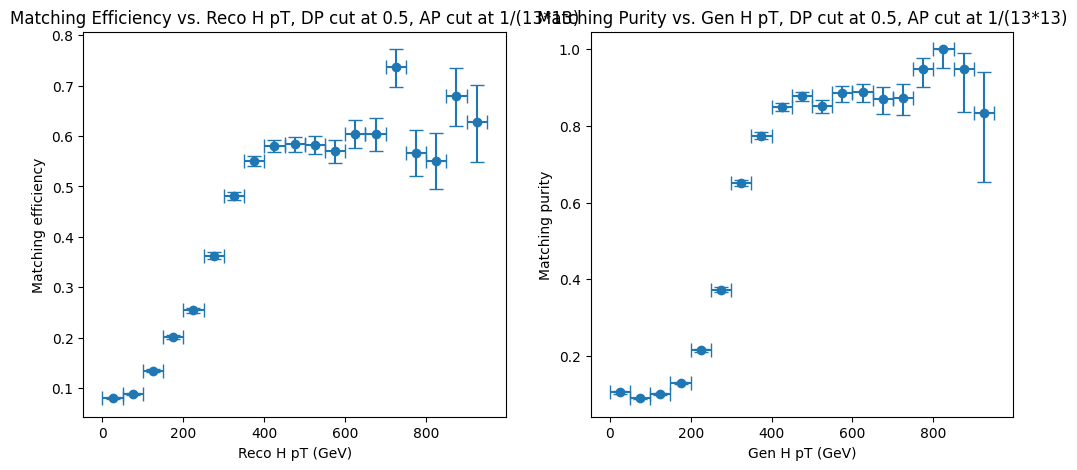

In [19]:
eff_s, efferr_s = calc_eff(LUT_boosted_pred, LUT_resolved_pred, bins)
pur_s, purerr_s = calc_pur(LUT_boosted_target, LUT_resolved_target, bins)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].errorbar(x=bin_centers, y=eff_s, xerr=xerr, yerr=efferr_s, fmt='o', capsize=5, label='Trust if a fatjet is assigned')
ax[0].set(xlabel=r"Reco H pT (GeV)", ylabel=r"Matching efficiency", title=f"Matching Efficiency vs. Reco H pT, DP cut at {dp_cut}, AP cut at 1/(13*13)")

ax[1].errorbar(x=bin_centers, y=pur_s, xerr=xerr, yerr=purerr_s, fmt='o', capsize=5, label='Trust if a fatjet is assigned')
ax[1].set(xlabel=r"Gen H pT (GeV)", ylabel=r"Matching purity", title=f"Matching Purity vs. Gen H pT, DP cut at {dp_cut}, AP cut at 1/(13*13)")

In [20]:
eff_s

<Array [0.0807, 0.0885, 0.135, ..., 0.551, 0.679, 0.627] type='19 * float64'>

In [21]:
pur_s

<Array [0.105, 0.089, 0.1, 0.13, ..., 1, 0.947, 0.833] type='19 * float64'>

In [22]:
a = [targetH[0:2] for event in LUT_resolved_target for targetH in event if targetH[2]==0]

In [23]:
len(a)

75266

In [24]:
b = [targetH for event in LUT_resolved_target for targetH in event]

In [25]:
len(b)

81810

In [26]:
len(LUT_resolved_target)

42829

In [27]:
c = [targetH[0:2] for event in LUT_resolved_pred for targetH in event if targetH[2]==0]

In [28]:
len(c)

64340

In [29]:
d = [targetH[0:2] for event in LUT_resolved_pred for targetH in event]

In [30]:
len(d)

75466